<a href="https://colab.research.google.com/github/injoon-pij/dlnlp-learning/blob/main/dlnlp_text_classification_by_rnn(Korean).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1) Naver Movie Review Sentiment Analysis

In [ ]:
!pip install konlpy

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1.1 Data load

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7fa47bd07250>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data))

훈련용 리뷰 개수 : 150000


In [ ]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 1.2 Data preprocessing

In [ ]:
# 중복 데이터 여부 확인
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

* 총 150,000개의 샘플이 존재하는데 document열에서 중복을 제거한 샘플의 개수가 146,182개라는 것은 약 4,000개의 중복 샘플이 존재한다는 의미

In [ ]:
# document 열에서 중복인 내용이 있다면 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True) # 원본에 적용

In [ ]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


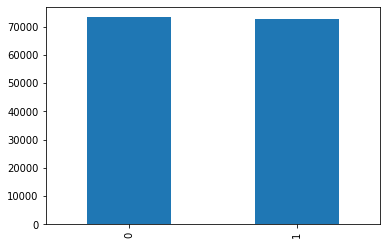

In [ ]:
# 레이블 값 분포 확인 (시각화)
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
# 레이블 값 분포 확인 (수치)
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [ ]:
# Null 값 존재 여부 확인
print(train_data.isnull().values.any())

# 어떤 열에 Null 값이 존재하는지 확인
print(train_data.isnull().sum())

True
id          0
document    1
label       0
dtype: int64


In [ ]:
# Null 값 데이터 인덱스 확인
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [ ]:
# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any')

# Null 값 존재 여부 재확인
print(train_data.isnull().values.any())

False


In [ ]:
print(len(train_data)) # 1개의 샘플이 제거되었음

146182


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


* 한글이 없는 리뷰였다면 이제 더 이상 아무런 값도 없는 빈(empty) 값이 되었을 것임

In [ ]:
# white space 데이터(빈 값)를 empty value("")로 통일하여 변경
train_data['document'] = train_data['document'].str.replace('^ +', "")

# empty value("")를 Null 값으로 변경
train_data['document'].replace('', np.nan, inplace=True)

print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [ ]:
# Null 값이 존재하는 행 제거
train_data = train_data.dropna(how = 'any')

# Null 값 존재 여부 재확인
print(train_data.isnull().values.any())

False


In [ ]:
print(len(train_data)) # 789개의 샘플이 제거되었음

145393


* 위 과정을 테스트 데이터에도 동일하게 적용

In [ ]:
# document 열에서 중복값 제거
test_data.drop_duplicates(subset = ['document'], inplace=True)

# 정규 표현식 수행 (한글과 공백 제외하고 전부 제거)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# white space 데이터(빈 값)를 empty value("")로 통일하여 변경
test_data['document'] = test_data['document'].str.replace('^ +', "")

# empty value("")를 Null 값으로 변경
test_data['document'].replace('', np.nan, inplace=True)

# Null 값 제거
test_data = test_data.dropna(how='any')

print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


## 1.3 Tokenization

In [ ]:
# 형태소 분석기
okt = Okt()

In [ ]:
# 토큰화 및 불용어 제거
X_train = []
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화 (stem=True : 정규화 수행)
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 145393/145393 [04:36<00:00, 526.47it/s]


In [ ]:
# 테스트 데이터에도 동일한 과정 적용
X_test = []

for sentence in tqdm(test_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [01:30<00:00, 541.16it/s]


## 1.4 Integer encoding

* 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수
total_freq = 0 # 전체 단어들의 등장 빈도수의 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어들의 등장 빈도수의 총합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24337
단어 집합에서 희귀 단어의 비율: 55.62488571950996
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8715872104872904


* 등장 빈도가 threshold 값인 3회 미만인 단어들은 단어 집합에서 무려 절반 이상을 차지하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.87%밖에 되지 않음
* 이러한 단어들을 자연어 처리에서 별로 중요하지 않은 단어들로 간주하고 정수 인코딩 과정에서 배제

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰과 OOV 토큰을 고려하여 + 2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19417


In [ ]:
# 정수 인코딩
tokenizer = Tokenizer(num_words = vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 1.5 Padding

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.001203634287759


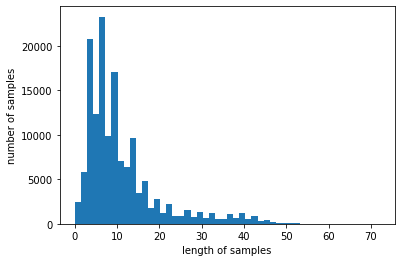

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수 정의
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.08362163240321


* 전체 훈련 데이터 중 약 94%의 리뷰가 30이하의 길이를 가짐

In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 1.6 Modeling

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1941700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,059,077
Trainable params: 2,059,077
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1818/1818 [==============================] - 105s 56ms/step - loss: 0.3896 - acc: 0.8230 - val_loss: 0.3524 - val_acc: 0.8449

Epoch 00001: val_acc improved from -inf to 0.84491, saving model to best_model.h5
Epoch 2/15
1818/1818 [==============================] - 102s 56ms/step - loss: 0.3267 - acc: 0.8574 - val_loss: 0.3325 - val_acc: 0.8550

Epoch 00002: val_acc improved from 0.84491 to 0.85498, saving model to best_model.h5
Epoch 3/15
1818/1818 [==============================] - 102s 56ms/step - loss: 0.3014 - acc: 0.8713 - val_loss: 0.3281 - val_acc: 0.8593

Epoch 00003: val_acc improved from 0.85498 to 0.85935, saving model to best_model.h5
Epoch 4/15
1818/1818 [==============================] - 102s 56ms/step - loss: 0.2828 - acc: 0.8820 - val_loss: 0.3263 - val_acc: 0.8600

Epoch 00004: val_acc improved from 0.85935 to 0.86004, saving model to best_model.h5
Epoch 5/15
1818/1818 [==============================] - 101s 56ms/step - loss: 0.2669 - acc: 0.8908 - val_loss:

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1527/1527 [==============================] - 14s 9ms/step - loss: 0.3315 - acc: 0.8576

 테스트 정확도: 0.8576


## 1.7 Predict

In [ ]:
def sentiment_predict(model, new_sentence, tokenizer, stopwords, t, max_len):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = tokenizer.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = t.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict(loaded_model, '이 영화 개꿀잼 ㅋㅋㅋ', okt, stopwords, tokenizer, max_len)

89.80% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict(loaded_model, '이딴 영화를 돈주고 본 내 잘못이다', okt, stopwords, tokenizer, max_len)

99.68% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict(loaded_model, '비싼 전복으로 라면을 끓였네', okt, stopwords, tokenizer, max_len)

80.55% 확률로 부정 리뷰입니다.


In [ ]:
sentiment_predict(loaded_model, '취향에 따라 호불호 갈리겠지만 개인적으로 이런 장르 난 극호', okt, stopwords, tokenizer, max_len)

64.68% 확률로 부정 리뷰입니다.


* 새로운 텍스트에 대해 비교적 잘 예측하지만, 아닌 경우도 존재함

# 2) Naver Shopping Review Sentiment Analysis

* 총 200,000개 리뷰로 구성된 데이터로 평점이 5점 만점에 1, 2, 4, 5인 리뷰들로 구성됨
* 3점인 리뷰는 긍부정 유무가 애매하여 데이터 구성 시에 제외되었음
* 평점이 4, 5인 리뷰들에 긍정을 의미하는 레이블 1을, 평점이 1, 2인 리뷰들에 부정을 의미하는 레이블 0을 부여

In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.3 MB/s 
     |████████████████████████████████| 86 kB 5.3 MB/s 
     |████████████████████████████████| 448 kB 51.0 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-10-20 04:45:31--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::34cc:ea4a, 2406:da00:ff00::22c3:9b0a, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=y6073aOLL%2B%2BCfovHO7trK8Nml2w%3D&Expires=1634706693&AWSAccessKeyId=AK

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2.1 Data load

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7fe0930aa110>)

In [ ]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 200000


* 해당 데이터에는 열제목이 별도로 없으므로 임의로 두 개의 열제목인 'ratings'와 'reviews'를 추가

In [ ]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


## 2.2 Data preprocessing

In [ ]:
# 평점이 4, 5인 리뷰에는 레이블 1을, 평점이 1, 2인 리뷰에는 레이블 0을 부여
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [ ]:
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

* 20만개의 리뷰 데이터가 존재하므로, 중복 샘플이 존재함을 알 수 있음

In [ ]:
# reviews 열에서 중복 샘플 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 199908


In [ ]:
# Null 값 유무 확인
print(total_data.isnull().values.any())

False


In [ ]:
# Data Split
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 149931
테스트용 리뷰의 개수 : 49977


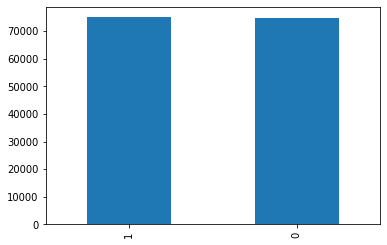

In [ ]:
# 레이블 분포 확인 (시각화)
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
# 레이블 분포 확인 (수치)
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  74918
1      1  75013


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

# white space 데이터(빈 값)를 empty value("")로 통일하여 변경
train_data['reviews'] = train_data['reviews'].str.replace('^ +', "")

# empty value("")를 Null 값으로 변경
train_data['reviews'].replace('', np.nan, inplace=True)

In [ ]:
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
# 테스트 데이터에도 동일한 과정 수행
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 

test_data['reviews'] = test_data['reviews'].str.replace('^ +', "")

test_data['reviews'].replace('', np.nan, inplace=True)

In [ ]:
print(test_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


In [ ]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 49977


## 2.3 Tokenization

In [ ]:
# 토크나이저
mecab = Mecab()

# 불용어
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

# 토큰화 및 불용어 제거
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [ ]:
train_data[:5]

,ratings,reviews,label,tokenized
59666,2,사이즈를 센치씩 늘린건데도 작아요 그리고 색상은 완전 달라요 칙칙한핑크네요ㅠㅠ 많이...,0,"[사이즈, 센치, 씩, 늘린, 건데, 작, 아요, 그리고, 색상, 완전, 달라요, ..."
12433,2,ㅂ불만족 빗이 아픔 멍이피부에 빗질못해주겟네요,0,"[ㅂ, 불, 만족, 빗이, 아픔, 멍, 피부, 빗, 질, 못해, 주, 겟, 네요]"
146516,1,이 제품쓰고 삼일만에 변기물이 잘 안내려갔어요 혹시나해서 다시 빼보니 물이 다시 잘...,0,"[제품, 쓰, 삼, 일, 만, 변기, 물, 잘, 안, 내려갔, 어요, 혹시나, 해서..."
158109,5,적당하고 만족합니다,1,"[적당, 만족, 합니다]"
70219,2,편하자고 이용하는 밀키튼데 손 은근 많이 가서 저는 패쓰요,0,"[편하, 자고, 이용, 밀키, 튼, 데, 손, 은근, 많이, 서, 저, 패, 쓰, 요]"


## 2.4 Words count & Review length

* 긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
# 부정 리뷰 상위 20개 단어
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [ ]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.587711463346354
부정 리뷰의 평균 길이 : 17.029472222963772


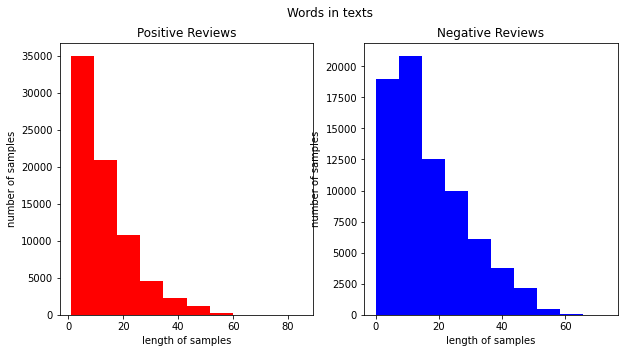

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Words in texts')

text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

## 2.5 Integer encoding

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 39996
등장 빈도가 1번 이하인 희귀 단어의 수: 18212
단어 집합에서 희귀 단어의 비율: 45.53455345534553
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.7935273405723314


* 등장 빈도가 1회인 희귀 단어들은 단어 집합에서 약 45%를 차지하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 0.8%밖에 되지 않음
* 이 단어들은 정수 인코딩 과정에서 배제

In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 21786


In [ ]:
# 토크나이저 생성
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)

# 정수 인코딩
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## 2.6 Padding

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307501450667306


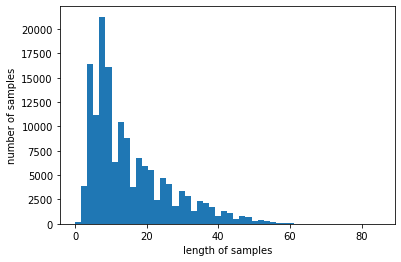

In [ ]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))

plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [ ]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율: 99.99933302652553


In [ ]:
# 훈련용 리뷰를 길이 80으로 패딩
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 2.7 Modeling

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         2178600   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 2,267,049
Trainable params: 2,267,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - 288s 153ms/step - loss: 0.2726 - acc: 0.8974 - val_loss: 0.2247 - val_acc: 0.9185

Epoch 00001: val_acc improved from -inf to 0.91853, saving model to best_model.h5
Epoch 2/15
1875/1875 [==============================] - 285s 152ms/step - loss: 0.2149 - acc: 0.9226 - val_loss: 0.2096 - val_acc: 0.9246

Epoch 00002: val_acc improved from 0.91853 to 0.92460, saving model to best_model.h5
Epoch 3/15
1875/1875 [==============================] - 285s 152ms/step - loss: 0.1992 - acc: 0.9289 - val_loss: 0.2059 - val_acc: 0.9260

Epoch 00003: val_acc improved from 0.92460 to 0.92603, saving model to best_model.h5
Epoch 4/15
1875/1875 [==============================] - 288s 154ms/step - loss: 0.1882 - acc: 0.9335 - val_loss: 0.2028 - val_acc: 0.9276

Epoch 00004: val_acc improved from 0.92603 to 0.92764, saving model to best_model.h5
Epoch 5/15
1875/1875 [==============================] - 292s 156ms/step - loss: 0.1790 - acc: 0.9372 - val_

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 36s 23ms/step - loss: 0.2102 - acc: 0.9248

 테스트 정확도: 0.9248


## 2.8 Predict

In [ ]:
def sentiment_predict(new_sentence, model, tokenizer, stopwords, t, max_len):
  new_sentence = tokenizer.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = t.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 상품 진짜 좋아요... 저는 강추합니다. 대박', loaded_model, mecab, stopwords, tokenizer, max_len)

98.68% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('배송이 늦긴했지만 상품은 만족스럽습니다!', loaded_model, mecab, stopwords, tokenizer, max_len)

88.37% 확률로 긍정 리뷰입니다.


In [ ]:
sentiment_predict('살짝 기대했던 것보다 별로긴 하지만 그럭저럭 만족합니다', loaded_model, mecab, stopwords, tokenizer, max_len)

63.49% 확률로 부정 리뷰입니다.


* 새로운 텍스트에 대해 비교적 잘 예측하지만, 아닌 경우도 존재함

# 3) Steam Review Sentiment Analysis

[BiLSTM을 텍스트 분류에 사용하기]

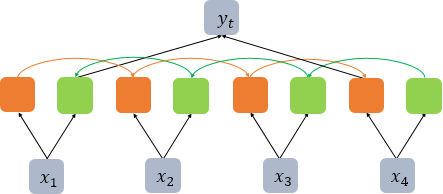

* 케라스에서는 양방향 LSTM을 사용하면서 return_sequences=False를 택할 경우, 정방향 LSTM는 마지막 시점의 은닉 상태를 반환하고, 역방향 LSTM는 첫번째 시점의 은닉 상태를 반환함

## 3.1 Data load

In [1]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 86 kB 4.5 MB/s 
     |████████████████████████████████| 448 kB 95.6 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-10-21 00:48:06--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/steam.txt", filename="steam.txt")

('steam.txt', <http.client.HTTPMessage at 0x7fc0c0a7a610>)

In [14]:
total_data = pd.read_table('steam.txt', names=['label', 'reviews'])
print('전체 리뷰 개수 :',len(total_data)) # 전체 리뷰 개수 출력

전체 리뷰 개수 : 100000


* 해당 데이터에는 열제목이 별도로 없으므로 두 개의 열제목인 'label'과 'reviews'를 추가해줌

In [5]:
total_data[:5]

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


## 3.2 Data preprocessing

In [15]:
total_data['reviews'].nunique(), total_data['label'].nunique()

(99892, 2)

* reviews열에서 중복을 제외한 경우는 99,892개인데 10만개의 리뷰가 존재하므로 이는 현재 갖고 있는 데이터에 중복인 샘플들이 있다는 의미

In [16]:
# reviews 열에서 중복 제거
total_data.drop_duplicates(subset=['reviews'], inplace=True)
print('총 샘플의 수 :',len(total_data))

총 샘플의 수 : 99892


In [17]:
# Null 값 유무 확인
print(total_data.isnull().values.any())

False


In [18]:
# Data Split
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰의 개수 :', len(train_data))
print('테스트용 리뷰의 개수 :', len(test_data))

훈련용 리뷰의 개수 : 74919
테스트용 리뷰의 개수 : 24973


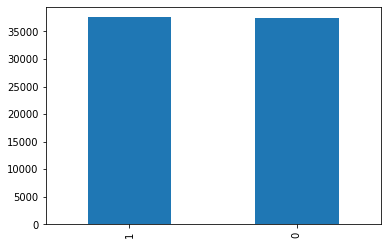

In [19]:
# 레이블 분포 확인 (시각화)
train_data['label'].value_counts().plot(kind = 'bar')

In [20]:
# 레이블 분포 확인 (수치)
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  37376
1      1  37543


In [ ]:
# 한글과 공백을 제외하고 모두 제거
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data['reviews'] = train_data['reviews'].str.replace("^ +","")
train_data['reviews'].replace('', np.nan, inplace=True)

In [23]:
print(train_data.isnull().sum())

label      0
reviews    0
dtype: int64


In [ ]:
# 테스트 데이터에도 동일하게 적용
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['reviews'] = test_data['reviews'].str.replace("^ +","")
test_data['reviews'].replace('', np.nan, inplace=True)

In [25]:
print(test_data.isnull().sum())

label      0
reviews    0
dtype: int64


## 3.3 Tokenization

In [26]:
mecab = Mecab()
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게', '만', '게임', '겜', '되', '음', '면']

In [ ]:
# 토큰화 및 불용어 제거
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

## 3.4 Words count & Review length

* 긍정 리뷰에는 주로 어떤 단어들이 많이 등장하고, 부정 리뷰에는 주로 어떤 단어들이 등장하는지 두 가지 경우에 대해서 각 단어의 빈도수를 계산

In [28]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [29]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('안', 8129), ('없', 7141), ('는데', 5786), ('있', 5692), ('같', 4247), ('로', 4083), ('할', 3920), ('거', 3902), ('나', 3805), ('해', 3654), ('너무', 3522), ('으로', 3351), ('기', 3348), ('했', 3265), ('어', 3143), ('보', 2987), ('습니다', 2962), ('것', 2935), ('지만', 2911), ('좋', 2899)]


In [30]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('있', 9987), ('좋', 6542), ('습니다', 5179), ('재밌', 4997), ('할', 4838), ('지만', 4809), ('해', 4355), ('없', 4145), ('보', 3907), ('으로', 3900), ('로', 3879), ('수', 3835), ('는데', 3825), ('기', 3592), ('안', 3368), ('것', 3362), ('같', 3356), ('네요', 3189), ('어', 3112), ('나', 3055)]


긍정 리뷰의 평균 길이 : 14.948405827983912
부정 리뷰의 평균 길이 : 15.284059289383562


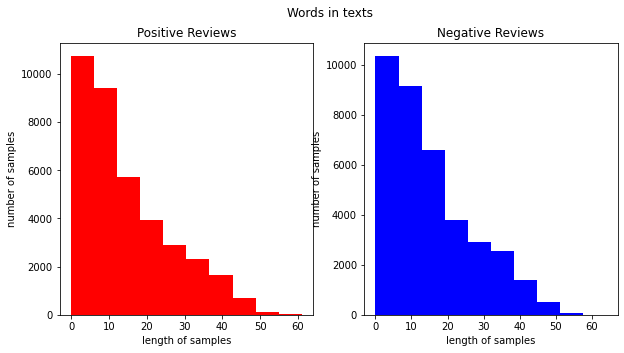

In [31]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Words in texts')

text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

## 3.5 Integer encoding

In [32]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [33]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [34]:
threshold = 2
total_cnt = len(tokenizer.word_index)
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총합

for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 32818
등장 빈도가 1번 이하인 희귀 단어의 수: 13880
단어 집합에서 희귀 단어의 비율: 42.29386312389543
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.22564494266931


* 등장 빈도가 1회인 단어들은 단어 집합에서 약 42%를 차지하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 매우 적은 수치인 약 1.2%밖에 되지 않으므로 이 단어들은 정수 인코딩 과정에서 배제

In [35]:
# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18940


In [36]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

## 3.6 Padding

리뷰의 최대 길이 : 64
리뷰의 평균 길이 : 15.115858460470642


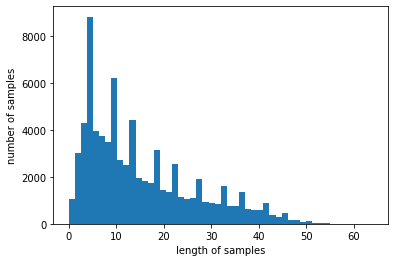

In [37]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [38]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [44]:
max_len = 45
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 45 이하인 샘플의 비율: 98.89080206623153


In [45]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

## 3.7 Modeling

In [46]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [47]:
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units)))
model.add(Dense(1, activation='sigmoid'))

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1894000   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 2,128,753
Trainable params: 2,128,753
Non-trainable params: 0
_________________________________________________________________


In [49]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [50]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
235/235 [==============================] - 99s 406ms/step - loss: 0.5126 - acc: 0.7495 - val_loss: 0.4886 - val_acc: 0.7776

Epoch 00001: val_acc improved from -inf to 0.77756, saving model to best_model.h5
Epoch 2/15
235/235 [==============================] - 95s 403ms/step - loss: 0.4302 - acc: 0.8051 - val_loss: 0.4631 - val_acc: 0.7864

Epoch 00002: val_acc improved from 0.77756 to 0.78637, saving model to best_model.h5
Epoch 3/15
235/235 [==============================] - 95s 404ms/step - loss: 0.4042 - acc: 0.8191 - val_loss: 0.4657 - val_acc: 0.7874

Epoch 00003: val_acc improved from 0.78637 to 0.78737, saving model to best_model.h5
Epoch 4/15
235/235 [==============================] - 95s 402ms/step - loss: 0.3849 - acc: 0.8309 - val_loss: 0.4598 - val_acc: 0.7865

Epoch 00004: val_acc did not improve from 0.78737
Epoch 5/15
235/235 [==============================] - 95s 404ms/step - loss: 0.3658 - acc: 0.8414 - val_loss: 0.4917 - val_acc: 0.7861

Epoch 00005: val_a

In [51]:
loaded_model = load_model('best_model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

781/781 [==============================] - 16s 19ms/step - loss: 0.4685 - acc: 0.7848
테스트 정확도: 0.7848


## 3.8 Predict

In [55]:
def sentiment_predict(new_sentence, model, tokenizer, stopwords, t, max_len):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = tokenizer.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = t.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [56]:
sentiment_predict('노잼 ..완전 재미 없음 ㅉㅉ', loaded_model, mecab, stopwords, tokenizer, max_len)

91.29% 확률로 부정 리뷰입니다.


In [57]:
sentiment_predict('케릭터가 예뻐서 좋아요', loaded_model, mecab, stopwords, tokenizer, max_len)

88.76% 확률로 긍정 리뷰입니다.


In [58]:
sentiment_predict('어렵긴 한데 이런 장르 매니아층은 환장하면서 켠왕할듯', loaded_model, mecab, stopwords, tokenizer, max_len)

92.21% 확률로 긍정 리뷰입니다.


In [59]:
sentiment_predict('그래픽이 이쁘다는 장점 외에는 하나도 장점을 찾을 수 없는 게임', loaded_model, mecab, stopwords, tokenizer, max_len)

82.19% 확률로 부정 리뷰입니다.


In [60]:
sentiment_predict('역시 전작 이기는 후속작은 없다', loaded_model, mecab, stopwords, tokenizer, max_len)

56.13% 확률로 긍정 리뷰입니다.


* 새로운 텍스트에 대해 비교적 잘 예측하지만, 아닌 경우도 존재함